In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.preprocessing import FunctionTransformer
import matplotlib.dates as mdates

#### 💾CARREGA E FILTRA OS DADOS

In [90]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# filtra CP 4610, converte e ordena
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

#### TARGET E LAG

In [91]:
# Define target e lag_168 (168h = 7dias)
df_cp["EnergyNormalized"] = df_cp["EnergyNormalized"].astype(float)
df_cp["lag_168"] = df_cp["EnergyNormalized"].shift(168)  # 168h atrás, hora a hora

# Modelos Tradicionais (Baseline)
# 📊ARIMA

#### MONTA O TimeSeriesDataFrame

In [92]:
# Define id e static features
df_cp["ZipCode"] = "4610"
static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()

# Cria o TimeSeriesDataFrame com target normalizado
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp[["DateTime", "ZipCode", "EnergyNormalized"]],
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🛠 SPLIT TREINO/TESTE: prever últimos 24h

In [93]:
# Define janela de previsão de 24 horas
prediction_length = 24

# Divide treino/teste: prevê o dia 30/09/2023 (00h–23h)
train_ts, test_ts = ts_df.train_test_split(prediction_length=prediction_length)

#### TARGET E LAG

In [94]:
# Mantém apenas os dados completos
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

#### 💾 (Opcional) Carregar um modelo existente

In [95]:
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA_daily/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_daily\modelo


#### 🛠️ Treinar

In [96]:
# Treina o modelo ARIMA
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=prediction_length,
    path="predicts/ARIMA_hourly/modelo",
    verbosity=2
).fit(
    train_data=train_ts,
    tuning_data=test_ts,
    hyperparameters={
        "ARIMAModel": {
            "order": (168, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard"
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_hourly\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       1.50 GB / 15.93 GB (9.4%)
Disk Space Avail:   690.65 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (168, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windo

#### 🔮 Previsão com os dados de treino

In [97]:
# Faz previsão para 30/09 (00h–23h)
future_preds = predictor_arima.predict(train_ts)

# extrai o quantil 0.5 e “desempacota” o índice de item_id
y_pred = future_preds["0.5"].droplevel(0)
y_true_full = test_ts["EnergyNormalized"].droplevel(0)

# extrai só os 24 valores reais que estão em test_ts
y_true = y_true_full.iloc[-prediction_length:]

Model not specified in predict, will default to the model with the best validation score: ARIMA


#### 📊  Avaliação do modelo

In [98]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²:   -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor     | Interpretação                                                                                   |
|--------------------------------------------|-----------|-------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.02499   | Em média, as previsões diferem dos valores reais em cerca de 0.025 na escala normalizada.       |
| **MSE** (Erro Quadrático Médio)            | 0.00097   | O erro médio ao quadrado é baixo, mas ainda assim revela variações não captadas pelo modelo.    |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.03117   | As previsões desviam-se em média 0.031 da realidade, o que pode ser significativo em certos horários. |
| **MAPE** (Erro Percentual Absoluto Médio)  | 47.82%    | As previsões apresentam um erro percentual elevado, indicando pouca fiabilidade relativa.       |
| **R²** (Coeficiente de Determinação)       | -15.00898 | O modelo ajusta-se muito mal aos dados: teve pior desempenho do que uma média constante.        |

#### 📈 Visualização dos resultados

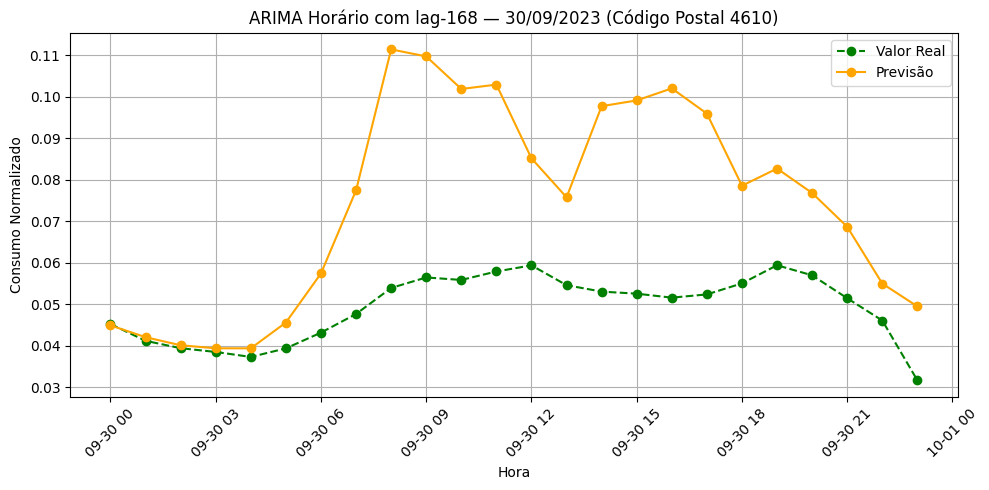

In [99]:
# valor real vs previsão
plt.figure(figsize=(10, 5))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão', color='orange')
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/arima_hourly_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
A utilização do ARIMA para prever o consumo energético **normalizado**, hora a hora, no dia **30/09/2023**, com base no valor da mesma hora da **semana anterior (`lag_168`)**, revelou um desempenho fraco. Apesar de o **MAE (0.025)** e o **RMSE (0.031)** parecerem baixos em valores absolutos, o **MAPE de 47.82%** indica que as previsões apresentam um erro percentual muito elevado, e o **R² fortemente negativo (−15.01)** confirma que o modelo foi incapaz de captar os padrões reais da série, sendo pior do que uma simples média constante. Este resultado mostra que, embora o `lag_168` capture a sazonalidade semanal, é claramente insuficiente por si só para modelar a complexidade e variabilidade do consumo energético em escala horária. A previsão horária requer, portanto, **modelos que suportem** lags adicionais de curto prazo e variáveis contextuais para melhorar a qualidade preditiva..

# Modelos ML & DL
# 📊RF

In [101]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

#### 💾 (Opcional) Carregar um modelo existente

In [102]:
pipeline = load("./predicts/RF_hourly/modelo/RF_pipeline.joblib")

#### ✂️ Split treino/teste

In [102]:
# Divide treino e teste
train_mask = df_cp["DateTime"] < "2023-09-30"
test_mask = df_cp["DateTime"].dt.date == pd.to_datetime("2023-09-30").date()

features = ["lag_168", "Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]
X_train = df_cp.loc[train_mask, features]
y_train = df_cp.loc[train_mask, "EnergyNormalized"]
X_test = df_cp.loc[test_mask, features]
y_test = df_cp.loc[test_mask, "EnergyNormalized"]

#### 🛠️ Treinar

In [104]:
# Pipeline
pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("num", StandardScaler(), ["lag_168"]),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"])
    ], remainder="drop")),
    ("rf", RandomForestRegressor(
        n_estimators=100, random_state=123, n_jobs=-1))
])

# Treina o modelo
pipeline.fit(X_train, y_train)

# Guarda
dump(pipeline, "predicts/RF_hourly/modelo/RF_pipeline_hourly.joblib")

['predicts/RF_hourly/modelo/RF_pipeline_hourly.joblib']

#### 🔮 Previsão com os dados de treino

In [105]:
y_pred = pipeline.predict(X_test)

#### 📊  Avaliação do modelo

In [106]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean()
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00340
MSE:  0.00002
RMSE: 0.00400
MAPE: 6.94984%
R²:   0.73680


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor    | Interpretação                                                                                      |
|---------------------------------------------|----------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)               | 0.00340  | Em média, a previsão difere dos valores reais em cerca de 0.0034 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)             | 0.00002  | O erro médio ao quadrado é muito baixo, indicando previsões consistentes.                          |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 0.00400  | O desvio médio das previsões em relação aos valores reais é de aproximadamente 0.0040.             |
| **MAPE** (Erro Percentual Absoluto Médio)   | 6.95%    | Em média, as previsões apresentam um erro percentual de 6.95% em relação aos valores reais.         |
| **R²** (Coeficiente de Determinação)        | 0.73680  | O modelo explica cerca de 73.68% da variabilidade do consumo energético normalizado horário.        |

#### 📈 Visualização dos resultados

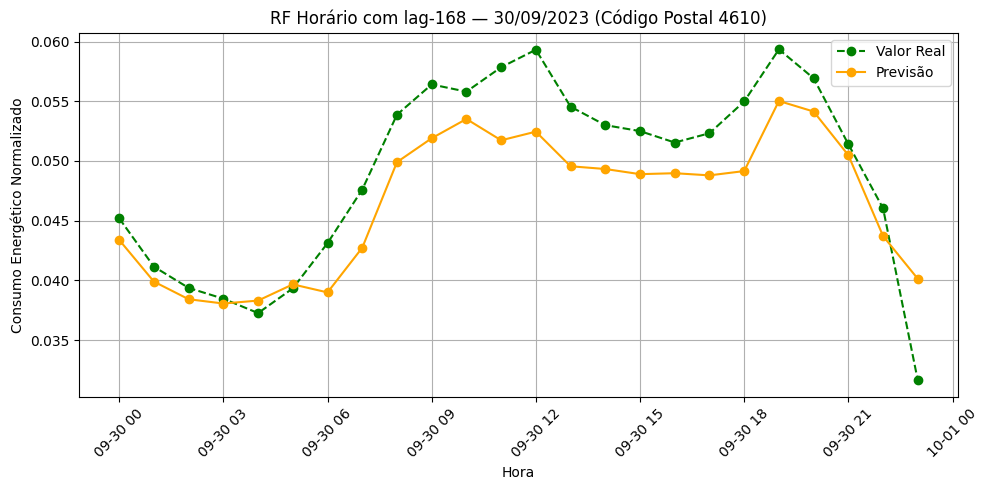

In [107]:
times = df_cp.loc[test_mask, "DateTime"]

plt.figure(figsize=(10, 5))
plt.plot(times, y_test.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(times, y_pred, marker='o', label='Previsão', color='orange')
plt.xlabel("Hora")
plt.ylabel("Consumo Energético Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("RF Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/RF_hourly_forecast_norm.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **Random Forest** aplicado à previsão do consumo energético **normalizado**, hora a hora, no dia **30/09/2023** para o código postal **4610**, com uso de `lag_168` e variáveis temporais, demonstrou um desempenho significativamente superior ao **ARIMA** na mesma tarefa. Com um **MAE de apenas 0.0034**, **RMSE de 0.0040** e um **R² de 0.7368**, o Random Forest conseguiu captar boa parte da variabilidade do consumo, mesmo numa escala horária onde os dados são mais ruidosos. Embora o **MAPE de 6.95%** indique ainda alguma margem de erro relativa, o desempenho é muito mais robusto quando comparado ao ARIMA, que apresentou um **R² negativo (−15.01)** e **MAPE extremamente elevado (47.82%)**, falhando em captar os padrões da série. Esta comparação evidencia que, para previsões horárias mais complexas, o uso de modelos como o Random Forest, que suportam **lags e variáveis contextuais explícitas**, é fundamental para obter resultados mais precisos e realistas.